In [23]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from tensorflow.contrib import rnn

% matplotlib inline
plt.style.use('ggplot')

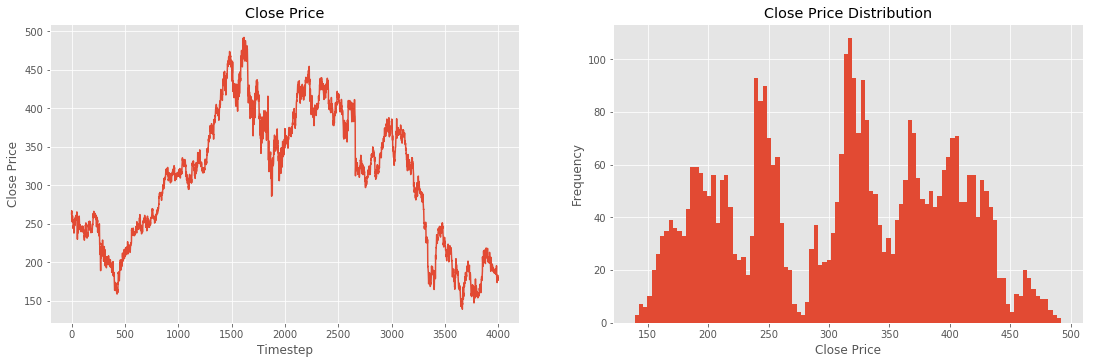

In [3]:
data_df = pd.read_csv('tsco.csv')
# We only care about close price for now 
data = data_df.Close.values

plt.subplot(1,2,1)
plt.plot(list(range(len(data))), data)
plt.xlabel('Timestep')
plt.ylabel('Close Price')
plt.title('Close Price')
plt.subplot(1,2,2)
plt.hist(data, 100)
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.title('Close Price Distribution')
fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)

In [4]:
# Normalise the data 
data_normal = data - np.mean(data)
data_normal = data_normal / np.std(data_normal)

print('Mean: {:2.2f} STD:{:2.2f}'.format(np.mean(data_normal), np.std(data_normal)))

Mean: -0.00 STD:1.00


In [10]:
# You should defintly review this section again

timesteps = list(range(len(data_normal)))
n_step = 3*7 # last three weeks
n_input = 1
n_output = 1 # next day stock only


useable_t = timesteps[n_step:-n_output]

past = np.empty((len(timesteps), n_step))
future = np.empty((len(timesteps), n_output))
for i, v in enumerate(useable_t):
    #print('Index: {}, Values: {} Procurement: {}' .format(i, v, proc_s.iloc[v]))
    past[v,:] = data_normal[v-n_step:v]
    future[v,:] = data_normal[v:v+n_output]
    
training_ratio = 0.8
training_size = int(len(useable_t)*training_ratio)
useable_past = past[useable_t]
useable_future = future[useable_t]

train_t = useable_t[:training_size]
test_t = useable_t[training_size:]


train_past = useable_past[:training_size]
train_future = useable_future[:training_size]

test_past = useable_past[training_size:]
test_future = useable_future[training_size:]

train_past = train_past.reshape((len(train_past), n_step, n_input))
test_past = test_past.reshape((len(test_past), n_step, n_input))

In [21]:
def my_rnn(x, W, b):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(x, n_step, axis=0)
    
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.nn.bias_add(tf.matmul(outputs[-1], W), b)

In [47]:
learning_rate = 1e-4
n_epoch = 20
epoch_size = 100
n_hidden = 256
n_iter = n_epoch * epoch_size

tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, n_step, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

W = tf.Variable(tf.truncated_normal([n_hidden, n_output]))
b = tf.Variable(tf.truncated_normal([n_output]))

h = my_rnn(x, W, b)

individual_losses = tf.reduce_mean(tf.squared_difference(h,y), 1)
loss = tf.reduce_mean(individual_losses)
optimiser = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [48]:
%%time 
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(n_iter+1):
    # No mini Batch yet
    optimiser.run(feed_dict={x:train_past, y:train_future})
    
    if iter% epoch_size ==0:
        print('Epoch: {} Loss: {}' .format(int(iter/epoch_size), loss.eval(feed_dict={x:train_past, y:train_future})))

Epoch: 0 Loss: 1.7025392055511475
Epoch: 1 Loss: 0.01109774224460125
Epoch: 2 Loss: 0.009086444973945618
Epoch: 3 Loss: 0.008140742778778076
Epoch: 4 Loss: 0.007341830991208553
Epoch: 5 Loss: 0.006697827950119972
Epoch: 6 Loss: 0.0062007359229028225
Epoch: 7 Loss: 0.0058272723108530045
Epoch: 8 Loss: 0.005545986350625753
Epoch: 9 Loss: 0.005325938109308481
Epoch: 10 Loss: 0.005143884103745222
Epoch: 11 Loss: 0.0049858917482197285
Epoch: 12 Loss: 0.00484484015032649
Epoch: 13 Loss: 0.004717319738119841
Epoch: 14 Loss: 0.004849044606089592
Epoch: 15 Loss: 0.004501355346292257
Epoch: 16 Loss: 0.004416045267134905
Epoch: 17 Loss: 0.004334231838583946
Epoch: 18 Loss: 0.004267160315066576
Epoch: 19 Loss: 0.00420661736279726
Epoch: 20 Loss: 0.004155318718403578
CPU times: user 1min 37s, sys: 35.3 s, total: 2min 12s
Wall time: 2min 51s


In [49]:
error = loss.eval(feed_dict={x:test_past, y:test_future})
print('Error on Test Set: {}' .format(error))

Error on Test Set: 0.0035449769347906113


# Measure Performance 

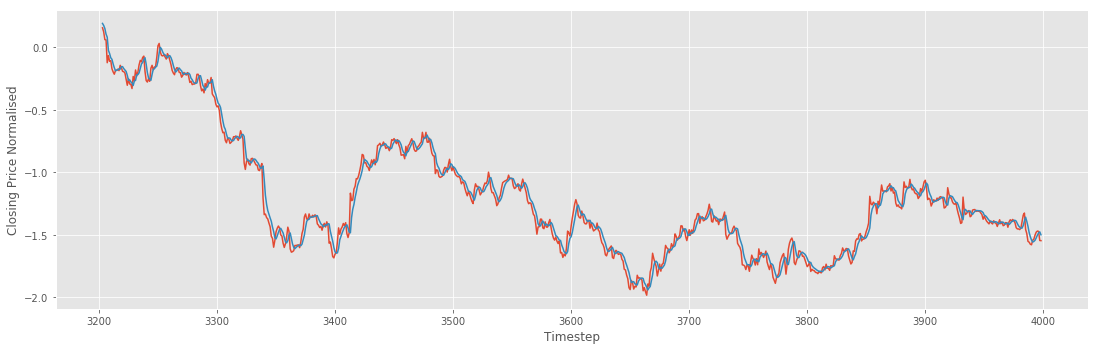

In [52]:
plt.plot(test_t, test_future)
plt.xlabel('Timestep')
plt.ylabel('Closing Price Normalised')
fcast = sess.run(h, feed_dict={x:test_past})
plt.plot(test_t, fcast)
#plt.plot(np.array(test_t)+1, test_future)
fig = plt.gcf()
fig.set_size_inches(18.5, 5.5)

In [51]:
def msre(x,y):
    return np.mean((x-y)**2)

print('Fcast Erro: {}' .format(msre(test_future, fcast)))
print('Fcast Erro: {}' .format(msre(test_future[:-1], test_future[1:])))

Fcast Erro: 0.00354497694978797
Fcast Erro: 0.0022516281552023548
